In [68]:
%matplotlib ipympl

import shap

In [2]:
import torch

# Choose the `slowfast_r50` model
model = torch.hub.load(
    "facebookresearch/pytorchvideo", "slowfast_r101", pretrained=True
)

Using cache found in /home/akshayn/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [3]:
import json
import urllib

from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
)
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)

/home/akshayn/miniconda3/envs/shiksha/lib/python3.11/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/akshayn/miniconda3/envs/shiksha/lib/python3.11/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [4]:
device = "cuda"
model = model.eval()
model = model.to(device)

In [5]:
json_url = "https://dl.fbaipublicfiles.com/pyslowfast/dataset/class_names/kinetics_classnames.json"
json_filename = "kinetics_classnames.json"
try:
    urllib.URLopener().retrieve(json_url, json_filename)
except:
    urllib.request.urlretrieve(json_url, json_filename)

In [6]:
with open(json_filename) as f:
    kinetics_classnames = json.load(f)

# Create an id to label name mapping
kinetics_id_to_classname = {}
for k, v in kinetics_classnames.items():
    kinetics_id_to_classname[v] = str(k).replace('"', "")

In [7]:
side_size = 256
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
crop_size = 256
num_frames = 32
sampling_rate = 2
frames_per_second = 30
slowfast_alpha = 4
num_clips = 10
num_crops = 3


class PackPathway(torch.nn.Module):
    """
    Transform for converting video frames as a list of tensors.
    """

    def __init__(self):
        super().__init__()

    def forward(self, frames: torch.Tensor):
        fast_pathway = frames
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            frames,
            1,
            torch.linspace(
                0, frames.shape[1] - 1, frames.shape[1] // slowfast_alpha
            ).long(),
        )
        frame_list = [slow_pathway, fast_pathway]
        return frame_list


inverse_subsample = ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            NormalizeVideo(
                mean=[-m / s for m, s in zip(mean, std)], std=[1 / s for s in std]
            ),
            Lambda(lambda x: x * 255),
        ]
    ),
)
transform_subsample = ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x / 255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(size=side_size),
            CenterCropVideo(crop_size),
        ]
    ),
)

transform = ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            # UniformTemporalSubsample(num_frames),
            # Lambda(lambda x: x/255.0),
            # NormalizeVideo(mean, std),
            # ShortSideScale(
            #     size=side_size
            # ),
            # CenterCropVideo(crop_size),
            PackPathway()
        ]
    ),
)

# The duration of the input clip is also specific to the model.
clip_duration = (num_frames * sampling_rate) / frames_per_second

In [8]:
url_link = "https://dl.fbaipublicfiles.com/pytorchvideo/projects/archery.mp4"
video_path = "archery.mp4"
try:
    urllib.URLopener().retrieve(url_link, video_path)
except:
    urllib.request.urlretrieve(url_link, video_path)

In [12]:
video_path = "../makeup.avi"

In [13]:
start_sec = 0
end_sec = start_sec + clip_duration

# Initialize an EncodedVideo helper class and load the video
video = EncodedVideo.from_path(video_path)

# Load the desired clip
video_data_raw = video.get_clip(start_sec=start_sec, end_sec=end_sec)
video_data_raw = transform_subsample(video_data_raw)
# Apply a transform to normalize the video input
video_data = transform(video_data_raw)

# Move the inputs to the desired device
inputs = video_data["video"]
inputs = [i.to(device)[None, ...] for i in inputs]

In [54]:
video_data_raw = video.get_clip(start_sec=start_sec, end_sec=end_sec)
print(
    video_data_raw["video"].mean(),
    video_data_raw["video"].std(),
    video_data_raw["video"].min(),
    video_data_raw["video"].max(),
)

video_data_raw = transform_subsample(video_data_raw)
print(
    video_data_raw["video"].mean(),
    video_data_raw["video"].std(),
    video_data_raw["video"].min(),
    video_data_raw["video"].max(),
)
video_data_raw = inverse_subsample(video_data_raw)
print(
    video_data_raw["video"].mean(),
    video_data_raw["video"].std(),
    video_data_raw["video"].min(),
    video_data_raw["video"].max(),
)
video_data_raw = transform_subsample(video_data_raw)
print(
    video_data_raw["video"].mean(),
    video_data_raw["video"].std(),
    video_data_raw["video"].min(),
    video_data_raw["video"].max(),
)

tensor(73.9470) tensor(49.7335) tensor(0.) tensor(255.)
tensor(-0.7398) tensor(0.8536) tensor(-2.) tensor(2.4444)
tensor(72.3065) tensor(48.9729) tensor(0.) tensor(255.)
tensor(-0.7398) tensor(0.8536) tensor(-2.) tensor(2.4444)


In [15]:
inputs[0].shape, inputs[1].shape

(torch.Size([1, 3, 8, 256, 256]), torch.Size([1, 3, 32, 256, 256]))

In [16]:
import gc


def call_vid(videos):
    input_slow = []
    input_fast = []
    for i in range(videos.shape[0]):
        vid = {"video": torch.from_numpy(videos[i, ...])}
        video_dict = transform(vid)
        inputs = video_dict["video"]
        input_slow.append(inputs[0].to(device))
        input_fast.append(inputs[1].to(device))

    input_slow = torch.stack(input_slow, dim=0).to(device)
    input_fast = torch.stack(input_fast, dim=0).to(device)
    with torch.no_grad():
        pred = model([input_slow, input_fast])
        post_act = torch.nn.Softmax(dim=1)
        preds = post_act(pred)
    torch.cuda.empty_cache()
    gc.collect()
    return preds

In [17]:
X = video_data_raw["video"]
X.shape

torch.Size([3, 32, 256, 256])

In [18]:
vid_masker = shap.maskers.Video("blur(3, 32, 32)", X.shape)

/home/akshayn/miniconda3/envs/shiksha/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [19]:
explainer = shap.PartitionExplainer(
    call_vid,
    vid_masker,
    output_names=[kinetics_id_to_classname[k] for k in kinetics_id_to_classname.keys()],
)

2024-03-29 11:33:08.627294: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-29 11:33:09.365028: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [20]:
X.shape

torch.Size([3, 32, 256, 256])

In [21]:
batch_size = 50
shap_values = explainer(
    X.reshape(-1, *X.shape),
    max_evals=128,
    batch_size=batch_size,
    outputs=shap.Explanation.argsort.flip[[0, 1, 2, 10, -2]],
)

/home/akshayn/miniconda3/envs/shiksha/lib/python3.11/site-packages/shap-0.0.0-py3.11-linux-x86_64.egg/shap/maskers/_video.py:96: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1008.)
  out = self.conv(input, weight=self.weight, groups=self.groups, padding = self.padding)


  0%|          | 0/126 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:14, 14.38s/it]               


In [22]:
(shap_values.data.shape, shap_values.values.shape)

(torch.Size([1, 3, 32, 256, 256]), (1, 3, 32, 256, 256, 5))

In [23]:
import numpy as np

with open("shap_video_data_new.npy", "wb") as f:
    np.save(f, shap_values.data.numpy())
with open("shap_video_values_new.npy", "wb") as f:
    np.save(f, shap_values.values)

In [24]:
import numpy as np

shap_value_data = np.load("shap_video_data_new.npy")
shap_value_value = np.load("shap_video_values_new.npy")

In [25]:
vid_slice_data = np.moveaxis(shap_value_data[0], 0, -1)[10]
vid_slice_value = [
    val for val in np.moveaxis(np.moveaxis(shap_value_value[0], 0, -2)[10], -1, 0)
]
for each in vid_slice_value:
    print(each.mean())

1.6333946935750042e-08
-1.604106181218867e-08
-1.995782798284532e-10
-1.47376251827259e-13
-5.592254813027682e-17


In [26]:
import shap

In [27]:
def subsample_xy_t(video, subsample_xy=True, n_xy=10, subsample_t=False, n_t=3):
    if subsample_xy:
        video = video[:, ::n_xy, ::n_xy]

    if subsample_t:
        video = video[::n_t, :, :]
    return video

In [28]:
from shap.plots.colors import red_transparent_blue

In [60]:
preds = call_vid(video_data_raw["video"].cpu().numpy()[None, ...])
pred_classes = preds.topk(k=5).indices[0]

# Map the predicted classes to the label names
pred_class_names = [kinetics_id_to_classname[int(i)] for i in pred_classes]
print("Top 5 predicted labels: %s" % ", ".join(pred_class_names))

Top 5 predicted labels: filling eyebrows, applying cream, waxing eyebrows, brush painting, crying


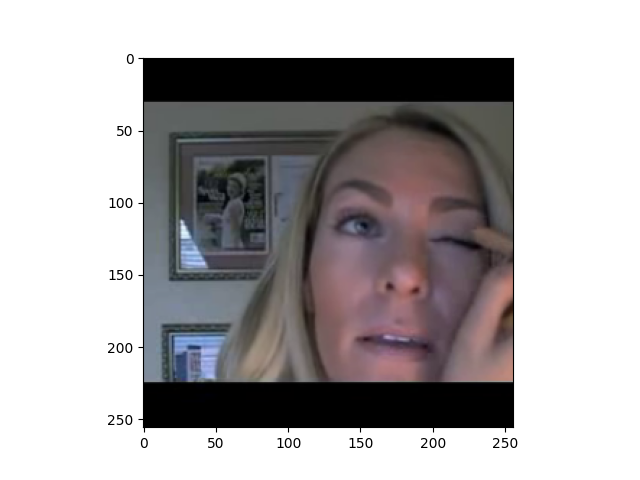

In [66]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

img = []
og_video = (
    inverse_subsample({"video": torch.from_numpy(shap_value_data[0])})["video"]
    .cpu()
    .numpy()
)
for shap_value_datas in np.moveaxis(og_video, 0, -1):
    img.append(np.array(shap_value_datas, dtype=np.uint8))
frames = []  # for storing the generated images
fig = plt.figure()

# Modify the loop to handle RGB images
for i in range(len(img)):
    frames.append([plt.imshow(img[i])])  # Remove cmap and animated parameters

ani = animation.ArtistAnimation(
    fig, frames, interval=1000 / 10, blit=False, repeat_delay=1000
)
plt.show()
from IPython.display import HTML

HTML(ani.to_jshtml())

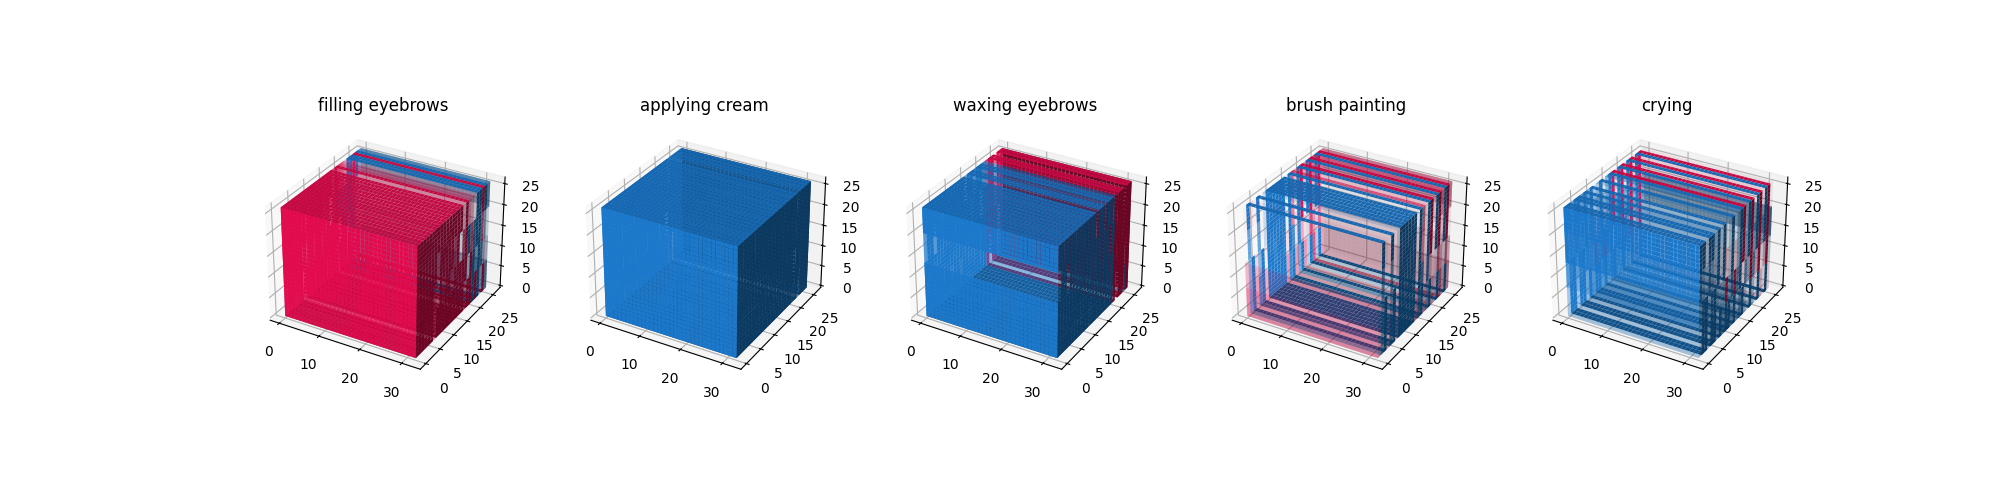

In [67]:
import matplotlib.pyplot as plt
import numpy as np

svs = np.moveaxis(shap_value_value[0].sum(0), -1, 0)
svs = np.array([subsample_xy_t(sv) for sv in svs])
facecolors_s = red_transparent_blue(svs / svs.std((1, 2, 3)).reshape(-1, 1, 1, 1))
# fig = plt.figure()
fig = plt.figure(
    figsize=(len(svs) * 4, 5)
)  # Adjust the figure size so each subplot has enough space
for i in range(len(svs)):
    # ax = fig.add_subplot(projection="3d")
    ax = fig.add_subplot(
        1, len(svs), i + 1, projection="3d"
    )  # 1 row, len(svs) columns, this is the i+1-th subplot

    ax.voxels(svs[i], facecolors=facecolors_s[i])
    ax.set_title(pred_class_names[i])
# facecolors = red_transparent_blue(sv_sub/sv_sub.std()) #(sv_sub - sv_sub.mean())/sv_sub.std())

# ax = fig.add_subplot(projection="3d")
# ax.voxels(sv_sub, facecolors=facecolors)
plt.show()